In [57]:
import jax.numpy as jnp
import numpy as np
from scipy import special
from scipy import stats
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan, cond
from jax import random
from jax import nn
import jax
import arviz as az
from matplotlib import pyplot as plt
import pandas as pd
az.rcParams["plot.max_subplots"] = 200
plt.rcParams.update({'font.size': 20})

from matplotlib import pyplot as plt

import os
import pickle
import setup

import seaborn as sns
from rl_models import *

from utils import plot_mean_hpdi, nanmovmean

key = random.PRNGKey(0)

In [58]:
processed_data_dir = "../data/Processed Sunapee High"
processed_file_name = "processed sunapee"
# processed_file_name = "excluded"
figure_data_dir = "/Users/f005d7d/Documents/Attn_MdPRL/Py-attention-project-analysis/figures/All Processed Sunapee High"

with open(os.path.join(processed_data_dir, processed_file_name), "rb") as f:
        data = pickle.load(f)
stims, stimsF0, stimsF1, full_rwd, choices, valid_mask = make_batch(data)

with open(os.path.join(processed_data_dir, "mcmc"), 'rb') as f:
    all_models_mcmc = pickle.load(f)

compare_dict = {}

for k, v in all_models_mcmc.items():
    inf_data = az.from_numpyro(v)
    log_lik = inf_data.log_likelihood
    log_lik['choice_total'] = log_lik.sum('choice_dim_0').to_array()
    compare_dict[k] = az.waic(inf_data, var_name='choice_total', pointwise=True)


print('loaded all models')
print('starting model comparisons')
comp_df = az.compare(compare_dict, ic='waic')
print(comp_df)

/Users/f005d7d/opt/miniconda3/envs/hbi/lib/python3.12/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/f005d7d/opt/miniconda3/envs/hbi/lib/python3.12/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/f005d7d/opt/miniconda3/envs/hbi/lib/python3.12/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/f005d7d/opt/miniconda3/envs/hbi/lib/python

loaded all models
starting model comparisons
       rank    elpd_waic     p_waic  elpd_diff        weight         se  \
F_AC      0 -2114.603217  71.160011   0.000000  6.231686e-01  47.850697   
F_ACL     1 -2118.359759  87.803207   3.756542  2.370355e-01  48.170848   
F_AL      2 -2118.847066  94.673515   4.243849  0.000000e+00  47.539452   
F_UA      3 -2140.676126  55.122295  26.072909  1.397959e-01  44.182536   
O         4 -2202.832846  54.493774  88.229629  6.816769e-13  37.456470   

             dse  warning scale  
F_AC    0.000000     True   log  
F_ACL   3.350490     True   log  
F_AL    2.840800     True   log  
F_UA    9.929519     True   log  
O      16.272595     True   log  


/Users/f005d7d/opt/miniconda3/envs/hbi/lib/python3.12/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/f005d7d/opt/miniconda3/envs/hbi/lib/python3.12/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/f005d7d/opt/miniconda3/envs/hbi/lib/python3.12/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\D'
/var/folders/vn/04h3k2gd41v70zhrqdwyg9cw0000gp/T/ipykernel_15090/1807219636.py:11: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta$ WAIC')


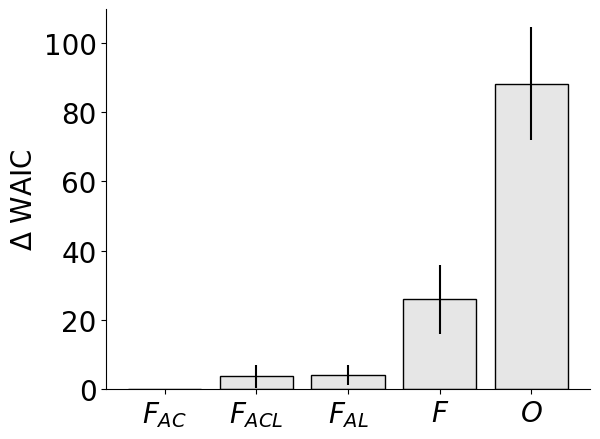

In [59]:
label_mapper = {
    'F_ACL': f'$F_{{ACL}}$',
    'F_AC': f'$F_{{AC}}$',
    'F_AL': f'$F_{{AL}}$',
    'F_UA': f'$F$',
    'O': f'$O$',
}

plt.bar(np.arange(comp_df.shape[0]), comp_df.loc[:,'elpd_diff'], edgecolor='black', facecolor=[0.9,0.9,0.9], yerr=comp_df.loc[:,'dse'])
plt.xticks(np.arange(comp_df.shape[0]), [label_mapper[name] for name in comp_df.index.values])
plt.ylabel('$\Delta$ WAIC')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(figure_data_dir, "rl_model_comparison.pdf"))


In [60]:
F_AC_model_inf_data = all_models_mcmc['F_AC']
F_AL_model_inf_data = all_models_mcmc['F_AL']
F_ACL_model_inf_data = all_models_mcmc['F_ACL']
F_UA_model_inf_data = all_models_mcmc['F_UA']
O_model_inf_data = all_models_mcmc['O']


F_AC_trialwise_waic = az.waic(F_AC_model_inf_data, pointwise=True)
F_ACL_trialwise_waic = az.waic(F_ACL_model_inf_data, pointwise=True)
F_AL_trialwise_waic = az.waic(F_AL_model_inf_data, pointwise=True)
F_UA_trialwise_waic = az.waic(F_UA_model_inf_data, pointwise=True)
O_trialwise_waic = az.waic(O_model_inf_data, pointwise=True)

/Users/f005d7d/opt/miniconda3/envs/hbi/lib/python3.12/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/f005d7d/opt/miniconda3/envs/hbi/lib/python3.12/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/f005d7d/opt/miniconda3/envs/hbi/lib/python3.12/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/f005d7d/opt/miniconda3/envs/hbi/lib/python

Text(0, 0.5, 'Models')

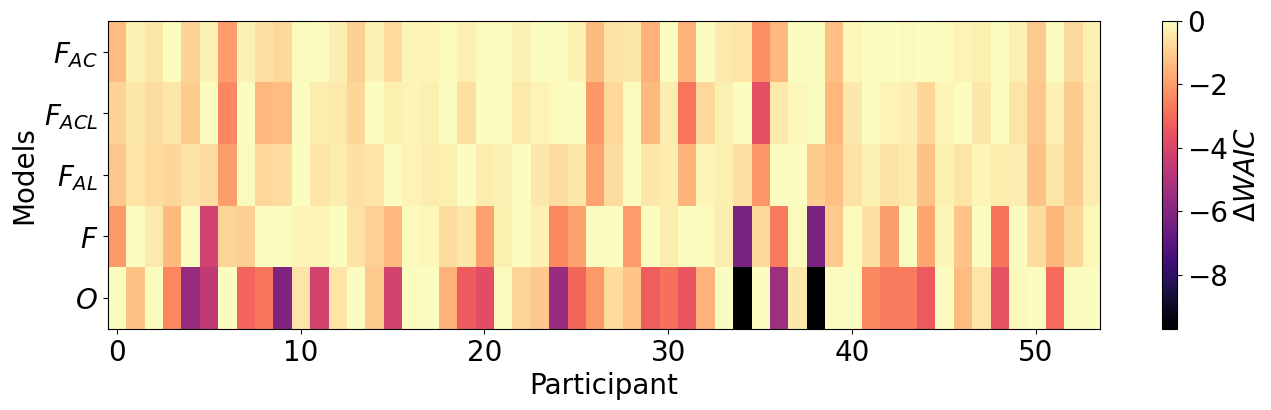

In [61]:
subj_waic = np.stack([
        F_AC_trialwise_waic.waic_i.values.sum(0),
        F_ACL_trialwise_waic.waic_i.values.sum(0),
        F_AL_trialwise_waic.waic_i.values.sum(0),
        F_UA_trialwise_waic.waic_i.values.sum(0),
        O_trialwise_waic.waic_i.values.sum(0),
    ])

normalized_subj_waic = subj_waic-subj_waic.max(axis=0,keepdims=True)
# normalized_subj_waic /= np.abs(normalized_subj_waic).max(axis=1 ,keepdims=True)

fig, axes = plt.subplots(1,1, figsize=(16,4))

plt.imshow(normalized_subj_waic, aspect='auto', cmap='magma')

plt.colorbar(label=r'$\Delta WAIC$')

axes.set_yticks(np.arange(comp_df.shape[0]), [label_mapper[name] for name in comp_df.index.values])

axes.set_xlabel('Participant')
axes.set_ylabel('Models')

In [33]:
np.argmax(subj_waic, axis=1)

array([4, 3, 4, 0, 3, 1, 4, 1, 3, 3, 1, 0, 3, 4, 1, 2, 4, 4, 1, 2, 1, 1,
       2, 0, 0, 1, 3, 3, 2, 3, 0, 3, 2, 0, 4, 1, 4, 2, 0, 0, 4, 4, 0, 0,
       3, 0, 4, 1, 3, 1, 3, 4, 0, 4, 4])

In [73]:
sess1 = ['8784', '0059', '1241', '7779', '1802', '7444', '4915', '9818', '3633']
sess2 = ['8487', '6379', '4763', '5968', '5150', '0427', '9417']
sess3 = ['4475', '3318', '5796', '8205', '4311', '9192', '2757', '4290', '2160']
sess4 = ['0524', '9762', '4791', '1427', '0683', '5166', '1477', '2755', '3544', '4953', '8895']
sess5 = ['0715', '0930', '7378', '6544', '2692', '9182', '5216', '8788', '2953', '7115',
         '6397', '0314', '1285', '6956', '7861', '1369', '7381']

all_sess_id = [sess1, sess2, sess3, sess4, sess5]

In [67]:
id_best_model_dict = dict(zip([d['ID'] for d in data], np.argmax(subj_waic, axis=0).tolist()))

In [68]:
id_best_model_dict

{5968: 4,
 5834: 3,
 4915: 4,
 8487: 0,
 5216: 3,
 1477: 1,
 427: 4,
 9417: 1,
 5166: 3,
 2755: 3,
 2757: 1,
 9762: 0,
 4290: 3,
 9818: 4,
 683: 1,
 6379: 2,
 2692: 4,
 8784: 4,
 4791: 1,
 7115: 2,
 524: 1,
 6544: 1,
 6397: 2,
 715: 0,
 3633: 0,
 930: 1,
 59: 3,
 3544: 3,
 7444: 2,
 8788: 3,
 7861: 0,
 4763: 3,
 314: 0,
 6956: 4,
 4953: 1,
 1802: 4,
 1427: 2,
 1369: 0,
 8205: 1,
 1285: 4,
 2160: 4,
 9182: 1,
 7378: 0,
 8895: 3,
 7779: 0,
 5796: 4,
 2953: 1,
 1241: 3,
 4311: 1,
 3318: 3,
 7381: 4,
 4475: 0,
 9192: 4,
 5150: 4}

In [74]:
for sess_id in all_sess_id:
    for subj_id in sess_id:
        print(subj_id, 'feature-based' if id_best_model_dict[int(subj_id)]<4 else 'object-based')
    print("==========")

8784 object-based
0059 feature-based
1241 feature-based
7779 feature-based
1802 object-based
7444 feature-based
4915 object-based
9818 object-based
3633 feature-based
8487 feature-based
6379 feature-based
4763 feature-based
5968 object-based
5150 object-based
0427 object-based
9417 feature-based
4475 feature-based
3318 feature-based
5796 object-based
8205 feature-based
4311 feature-based
9192 object-based
2757 feature-based
4290 feature-based
2160 object-based
0524 feature-based
9762 feature-based
4791 feature-based
1427 feature-based
0683 feature-based
5166 feature-based
1477 feature-based
2755 feature-based
3544 feature-based
4953 feature-based
8895 feature-based
0715 feature-based
0930 feature-based
7378 feature-based
6544 feature-based
2692 object-based
9182 feature-based
5216 feature-based
8788 feature-based
2953 feature-based
7115 feature-based
6397 feature-based
0314 feature-based
1285 object-based
6956 object-based
7861 feature-based
1369 feature-based
7381 object-based


In [76]:
az.summary(az.from_numpyro(all_models_mcmc['F_AC']), var_names=['mu', 'sigma'], stat_focus='median', hdi_prob=0.95)

,median,mad,eti_2.5%,eti_97.5%,mcse_median,ess_median,ess_tail,r_hat
mu[0],-0.001,0.026,-0.078,0.074,0.000,11601.755,5210.0,1.00
mu[1],1.074,0.176,0.570,1.600,0.007,2105.599,3582.0,1.00
mu[2],0.279,0.257,-0.559,0.984,0.009,2569.880,3347.0,1.00
mu[3],-1.149,0.137,-1.556,-0.756,0.005,2772.963,4099.0,1.00
mu[4],-2.892,0.276,-3.918,-2.219,0.006,6838.384,5345.0,1.00
mu[5],-3.088,0.274,-4.092,-2.439,0.005,8398.824,5178.0,1.00
mu[6],-1.635,0.192,-2.322,-1.111,0.007,3266.351,4157.0,1.00
mu[7],-2.012,0.255,-3.071,-1.413,0.009,3250.837,1883.0,1.00
sigma[0],0.041,0.025,0.002,0.137,0.001,5454.647,3792.0,1.00
sigma[1],0.540,0.116,0.187,0.923,0.005,2237.589,1557.0,1.00


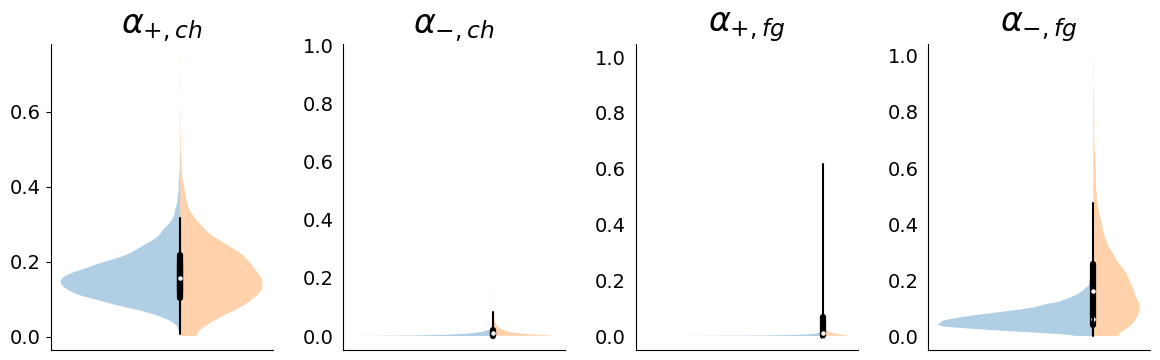

In [135]:
inf_data = az.from_numpyro(all_models_mcmc['F_ACL'])
post = inf_data.posterior

lr_start = 3

fig, axes = plt.subplots(1,4,figsize=(12,4))


post['alpha+_c,0'] = special.ndtr(post['mu'][...,lr_start])
post['alpha+_c,1'] = special.ndtr(post['mu'][...,lr_start+2])
post['alpha-_c,0'] = special.ndtr(post['mu'][...,lr_start+1])
post['alpha-_c,1'] = special.ndtr(post['mu'][...,lr_start+3])

post['alpha+_f,0'] = special.ndtr(post['mu'][...,lr_start+4])
post['alpha+_f,1'] = special.ndtr(post['mu'][...,lr_start+6])
post['alpha-_f,0'] = special.ndtr(post['mu'][...,lr_start+5])
post['alpha-_f,1'] = special.ndtr(post['mu'][...,lr_start+7])


az.plot_violin(
    inf_data,
    var_names=['alpha+_c,0', 'alpha-_c,0', 
                'alpha+_f,0', 'alpha-_f,0'],
    side="left",
    ax=axes,
    hdi_prob=0.95,
    sharey=True,
)
az.plot_violin(
    inf_data,
    var_names=['alpha+_c,1', 'alpha-_c,1', 
                'alpha+_f,1', 'alpha-_f,1'],
    side="right",
    ax=axes,
    hdi_prob=0.95,
    sharey=True,
)

axes[0].set_title(r'$\alpha_{+, ch}$')
axes[1].set_title(r'$\alpha_{-, ch}$')
axes[2].set_title(r'$\alpha_{+, fg}$')
axes[3].set_title(r'$\alpha_{-, fg}$')

sns.despine()
fig.tight_layout()

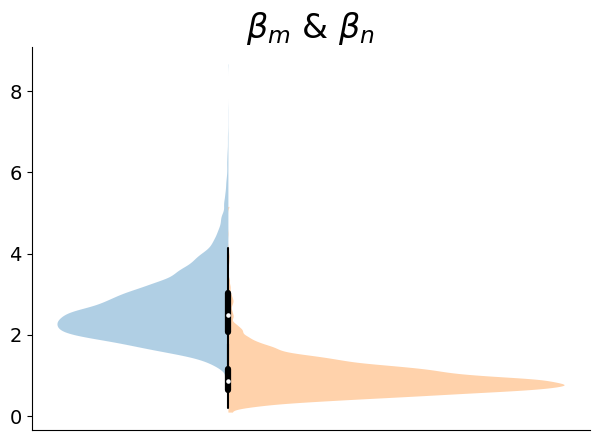

In [130]:
post['beta0'] = np.exp(post['mu'][...,1])
post['beta1'] = np.exp(post['mu'][...,2])

fig, axes = plt.subplots(1,1)

az.plot_violin(
    inf_data,
    var_names=['beta0'],
    side='left',
    ax = axes,
    hdi_prob=0.95,
)

az.plot_violin(
    inf_data,
    var_names=['beta1'],
    side='right',
    ax = axes,
    hdi_prob=0.95,
)

axes.set_title(r'$\beta_{m}\ &\ \beta_{n}$')

sns.despine()
fig.tight_layout()



In [110]:
subj_params = np.median(post['subj_params'], axis=(0,1))
subj_params[:,[1,2]] = np.exp(subj_params[:,[1,2]])
subj_params[:,3:] = special.ndtr(subj_params[:,3:])

In [108]:
([str(d['ID']) for d in data])

['5968',
 '5834',
 '4915',
 '8487',
 '5216',
 '1477',
 '427',
 '9417',
 '5166',
 '2755',
 '2757',
 '9762',
 '4290',
 '9818',
 '683',
 '6379',
 '2692',
 '8784',
 '4791',
 '7115',
 '524',
 '6544',
 '6397',
 '715',
 '3633',
 '930',
 '59',
 '3544',
 '7444',
 '8788',
 '7861',
 '4763',
 '314',
 '6956',
 '4953',
 '1802',
 '1427',
 '1369',
 '8205',
 '1285',
 '2160',
 '9182',
 '7378',
 '8895',
 '7779',
 '5796',
 '2953',
 '1241',
 '4311',
 '3318',
 '7381',
 '4475',
 '9192',
 '5150']

In [114]:
subj_param_df = pd.DataFrame(subj_params.round(3), 
             index=[str(d['ID']).zfill(4) for d in data],
             columns=['bias', 'beta_m', 'beta_n', 'alpha_+,ch', 'alpha_-,ch', 'alpha_+,fg', 'alpha_-,fg', 'decay'])

In [119]:
subj_param_df.loc[sess5]

,bias,beta_m,beta_n,"alpha_+,ch","alpha_-,ch","alpha_+,fg","alpha_-,fg",decay
0715,0.008,2.984,1.119,0.126,0.002,0.001,0.047,0.020
0930,0.007,3.177,0.781,0.120,0.002,0.001,0.057,0.020
7378,0.006,3.307,0.688,0.098,0.002,0.001,0.055,0.018
6544,-0.010,2.370,0.841,0.083,0.002,0.001,0.043,0.025
2692,-0.002,2.157,0.968,0.089,0.002,0.001,0.036,0.031
9182,0.001,3.482,1.001,0.133,0.002,0.001,0.071,0.026
5216,-0.001,4.592,2.285,0.147,0.002,0.001,0.096,0.016
8788,0.006,2.877,3.135,0.154,0.002,0.001,0.072,0.050
2953,-0.002,2.940,0.881,0.122,0.002,0.001,0.051,0.019
7115,0.001,3.822,1.274,0.129,0.002,0.001,0.039,0.010


In [127]:
def plot_learning_curve_FO(data, best_m):
    num_trials = data[0]['numTrials']
    num_subj = len(data)
    perf_all_F = []
    perf_all_O = []
    window_size = 20
    for idx_subj, sesdata in enumerate(data):
        unambiguous_choose_better = sesdata['choose_better'].astype(float)
        unambiguous_choose_better[sesdata['probs'][:,0]==sesdata['probs'][:,1]] = np.nan
        if best_m[idx_subj]<4:
            perf_all_F.append(nanmovmean(unambiguous_choose_better, window_size))
        else:
            perf_all_O.append(nanmovmean(unambiguous_choose_better, window_size))
        # plt.plot(perf_all[-1].T)
        # plt.show()
    perf_all_F = np.stack(perf_all_F)
    perf_all_O = np.stack(perf_all_O)

    m_perf_F = np.nanmean(perf_all_F, 0)
    m_perf_O = np.nanmean(perf_all_O, 0)

    sd_perf_F = np.nanstd(perf_all_F, 0)/np.sqrt(num_subj)
    sd_perf_O = np.nanstd(perf_all_O, 0)/np.sqrt(num_subj)

    plt.plot(m_perf_F, color='brown')
    plt.fill_between(np.arange(perf_all_F.shape[1]), m_perf_F-sd_perf_F, m_perf_F+sd_perf_F, color='brown', alpha=0.2, label='Feature-based')
    plt.plot(m_perf_O, color='green')
    plt.fill_between(np.arange(perf_all_O.shape[1]), m_perf_O-sd_perf_O, m_perf_O+sd_perf_O, color='green', alpha=0.2, label='Object-based')

    sns.despine()
    # plt.ylim([0.52, 0.85])
    plt.xlabel('Trial', fontsize=20)
    plt.ylabel('Prob. correct', fontsize=20)
    plt.legend(fontsize=18)
    plt.tight_layout()

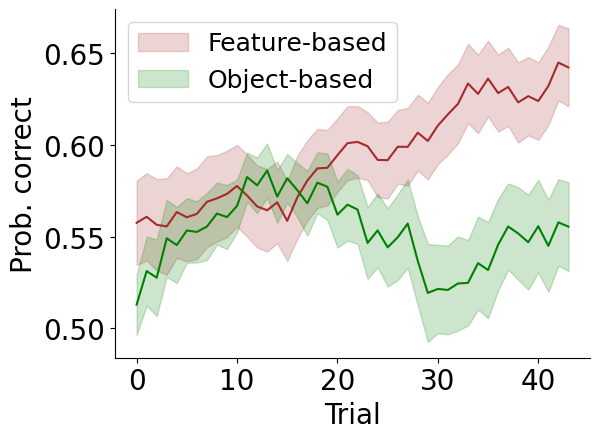

In [128]:
plot_learning_curve_FO(data, np.argmax(subj_waic, axis=0).tolist())